<a href="https://colab.research.google.com/github/nitinranjansharma/EIP4-Week1/blob/master/Week5/Assignment5InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data only first run for a session
from google.colab import drive
drive.mount('/content/mydrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/mydrive


In [0]:
#!unzip -q "/content/mydrive/My Drive/colabProjects/EIP4/hvc_data.zip"

In [0]:
# for second run onwards
import os
root_dir = "/content/mydrive/My Drive/colabProjects/EIP4/"
os.chdir(root_dir)

In [0]:
# utility function 1


import numpy as np
from random import randint

def myFunc(input_img,p = 0.2, s_l=0.02, s_h=0.04, r_1=0.3, r_2=1/0.3,v_l=0, v_h=255, pixel_level=False):
    #image = np.array(image)
    x = randint(0,16)
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()
    if p_1 > p:
      return input_img

    while True:
      s = np.random.uniform(s_l, s_h) * img_h * img_w
      r = np.random.uniform(r_1, r_2)
      w = int(np.sqrt(s / r))
      h = int(np.sqrt(s * r))
      left = np.random.randint(0, img_w)
      top = np.random.randint(0, img_h)
      if left + w <= img_w and top + h <= img_h:
        break
    if pixel_level:
      c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
      c = np.random.uniform(v_l, v_h)
    input_img[top:top + h, left:left + w, :] = c
    return(input_img)

In [4]:
import tensorflow as tf
#import tensorflow.contrib.eager as tfe
#tf.enable_eager_execution()

In [5]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
            base = 0.001 max = 0.006
    """

    def __init__(self, base_lr=0.001, max_lr=0.05, step_size=300., mode='exp_range',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

Using TensorFlow backend.


In [0]:
from keras.callbacks import *

clr_triangular = CyclicLR(mode='triangular2')

In [0]:
# importing packages an dependencies
%tensorflow_version 1.x

import cv2
import json
import os

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization, Activation
from keras.layers import Convolution2D, MaxPooling2D


In [0]:
import os
import zipfile
from skimage import io

from keras.preprocessing import image
from keras import backend as K
from keras.applications.vgg16 import preprocess_input

In [0]:
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout

In [10]:

df = pd.read_csv("./hvc_annotations.csv")
print(df.shape)

(13573, 10)


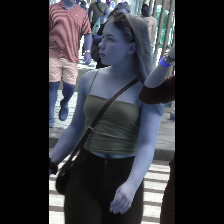

(224, 224, 3)


In [11]:
#display sample images
from google.colab.patches import cv2_imshow
ext_img = io.imread("resized/8335.jpg")
cv2_imshow(ext_img)
print(ext_img.shape)



In [11]:
one_hot_df = pd.concat([
                        df[['image_path']],
                        pd.get_dummies(df['gender'], prefix = "gender"),
                        pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose")
                        ], axis = 1)
one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np
import tensorflow as tf

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=16,shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
      

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        try:
          batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
          
          items = self.df.iloc[batch_slice]
          #image = np.stack([io.imread(item["image_path"]) for _, item in items.iterrows()])
          
          image = np.stack([myFunc(io.imread(item["image_path"])) for _, item in items.iterrows()])
          
          #print(image.shape)
          
          #print(image.shape)
          '''
          
          print("checking images")
          for _,item in items.iterrows():
            
            imageTemp = io.imread(item["image_path"])
            print("data aug images")
            imageTemp = imageTemp.map(data_aug)
            print("data aug images end")
            print(imageTemp.shape)
            image = np.stack(imageTemp)
          '''
            


          #image aug
          
          

          if image is None:
            pass
          target = {
              "gender_output": items[_gender_cols_].values,
              "image_quality_output": items[_imagequality_cols_].values,
              "age_output": items[_age_cols_].values,
              "weight_output": items[_weight_cols_].values,
              "bag_output": items[_carryingbag_cols_].values,
              "pose_output": items[_bodypose_cols_].values,
              "footwear_output": items[_footwear_cols_].values,
              "emotion_output": items[_emotion_cols_].values,
          }
          
          return (image, target)
        except:
            print("exception")
          
            pass

        #print(image.shape)
        

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [0]:
import keras
import numpy as np
import tensorflow as tf

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGeneratorVal(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=16,shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
      

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        try:
          batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
          
          items = self.df.iloc[batch_slice]
          image = np.stack([io.imread(item["image_path"]) for _, item in items.iterrows()])
          
          #image = np.stack([myFunc(io.imread(item["image_path"])) for _, item in items.iterrows()])
          
          #print(image.shape)
          
          #print(image.shape)
          '''
          
          print("checking images")
          for _,item in items.iterrows():
            
            imageTemp = io.imread(item["image_path"])
            print("data aug images")
            imageTemp = imageTemp.map(data_aug)
            print("data aug images end")
            print(imageTemp.shape)
            image = np.stack(imageTemp)
          '''
            


          #image aug
          
          

          if image is None:
            pass
          target = {
              "gender_output": items[_gender_cols_].values,
              "image_quality_output": items[_imagequality_cols_].values,
              "age_output": items[_age_cols_].values,
              "weight_output": items[_weight_cols_].values,
              "bag_output": items[_carryingbag_cols_].values,
              "pose_output": items[_bodypose_cols_].values,
              "footwear_output": items[_footwear_cols_].values,
              "emotion_output": items[_emotion_cols_].values,
          }
          
          return (image, target)
        except:
            print("exception")
          
            pass

        #print(image.shape)
        

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1,random_state=111).reset_index(drop=True)

In [14]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state = 111)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:

# create train and validation data generators
root_dir = "/content/mydrive/My Drive/colabProjects/EIP4/"
os.chdir(root_dir)

train_gen = PersonDataGenerator(train_df, batch_size=16)
valid_gen = PersonDataGeneratorVal(val_df, batch_size=16, shuffle=False)

In [16]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = {k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

# Model creation

## Model plot

## Inception Model

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

backend = keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils

from keras import applications
from keras_applications.imagenet_utils import _obtain_input_shape

In [0]:
def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
    """Utility function to apply conv + BN.
    # Arguments
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
    # Returns
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if backend.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = layers.Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = layers.BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = layers.Activation('relu', name=name)(x)
    return x


In [0]:
def InceptionV3(include_top=True,
                input_tensor=None,
                input_shape=None,
                **kwargs):
    """Instantiates the Inception v3 architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(299, 299, 3)` (with `channels_last` data format)
            or `(3, 299, 299)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 75.
            E.g. `(150, 150, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    weights = None 
    

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    backend = keras.backend
    layers = keras.layers
    models = keras.models
    keras_utils = keras.utils
    
    input_shape = _obtain_input_shape(
        input_shape,
        default_size=299,
        min_size=75,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if backend.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    # input img can be modulated and broken down here #
    conv = Conv2D(filters = 16,
                  kernel_size=(3,3),
                  strides=(1,1),
                  padding='same',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=l2(1e-2))
    x1 = conv(img_input)
    x1 = BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = Conv2D(filters = 32,kernel_size=(3,3),strides=(1,1))(x1)
    x1 = BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x2 = conv(img_input)
    x2 = BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = Conv2D(filters = 32,kernel_size=(3,3),strides=(1,1))(x2)
    x2 = BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x3 = conv(img_input)
    x3 = BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = Conv2D(filters = 32,kernel_size=(3,3),strides=(1,1))(x3)
    x3 = BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x4 = conv(img_input)
    x4 = BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = Conv2D(filters = 32,kernel_size=(3,3),strides=(1,1))(x4)
    x4 = BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)

    x = keras.layers.Add()([x1,x2,x3,x4])

    #1 block

    x = conv2d_bn(x, 32, 3, 3, strides=(2, 2), padding='valid') # ends up at 111*111*32
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # parallel mix branch starts expects 25*25*192

    # mixed 0: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed0')

    # mixed 1: 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed1')

    # mixed 2: 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed2')

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(
        branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = layers.AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch7x7x3, branch_pool],
        axis=channel_axis,
        name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2],
            axis=channel_axis,
            name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = layers.AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(9 + i))

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='inception_v3')
    return model

# Initial head changes

In [0]:
# initial head changes
def InceptionV3(include_top=True,
                input_tensor=None,
                input_shape=None,
                **kwargs):
    """Instantiates the Inception v3 architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(299, 299, 3)` (with `channels_last` data format)
            or `(3, 299, 299)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 75.
            E.g. `(150, 150, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    weights = None 
    

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    backend = keras.backend
    layers = keras.layers
    models = keras.models
    keras_utils = keras.utils
    
    input_shape = _obtain_input_shape(
        input_shape,
        default_size=299,
        min_size=75,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if backend.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    # input img can be modulated and broken down here #
    conv = Conv2D(filters = 16,
                  kernel_size=(3,3),
                  strides=(1,1),
                  padding='same',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=l2(1e-2))


    #1 block

    x1 = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid') # ends up at 111*111*32
    x1 = conv2d_bn(x1, 32, 3, 3, padding='valid')
    x1 = conv2d_bn(x1, 64, 3, 3)
    x1 = layers.MaxPooling2D((3, 3), strides=(2, 2))(x1)

    x1 = conv2d_bn(x1, 80, 1, 1, padding='valid')
    x1 = conv2d_bn(x1, 192, 3, 3, padding='valid')
    x1 = layers.MaxPooling2D((3, 3), strides=(2, 2))(x1)

    x2 = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid') # ends up at 111*111*32
    x2 = conv2d_bn(x2, 32, 3, 3, padding='valid')
    x2 = conv2d_bn(x2, 64, 3, 3)
    x2 = layers.MaxPooling2D((3, 3), strides=(2, 2))(x2)

    x2 = conv2d_bn(x2, 80, 1, 1, padding='valid')
    x2 = conv2d_bn(x2, 192, 3, 3, padding='valid')
    x2 = layers.MaxPooling2D((3, 3), strides=(2, 2))(x2)

    x3 = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid') # ends up at 111*111*32
    x3 = conv2d_bn(x3, 32, 3, 3, padding='valid')
    x3 = conv2d_bn(x3, 64, 3, 3)
    x3 = layers.MaxPooling2D((3, 3), strides=(2, 2))(x3)

    x3 = conv2d_bn(x3, 80, 1, 1, padding='valid')
    x3 = conv2d_bn(x3, 192, 3, 3, padding='valid')
    x3 = layers.MaxPooling2D((3, 3), strides=(2, 2))(x3)

    x4 = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid') # ends up at 111*111*32
    x4 = conv2d_bn(x4, 32, 3, 3, padding='valid')
    x4 = conv2d_bn(x4, 64, 3, 3)
    x4 = layers.MaxPooling2D((3, 3), strides=(2, 2))(x4)

    x4 = conv2d_bn(x4, 80, 1, 1, padding='valid')
    x4 = conv2d_bn(x4, 192, 3, 3, padding='valid')
    x4 = layers.MaxPooling2D((3, 3), strides=(2, 2))(x4)

    x = keras.layers.concatenate([x1,x2,x3,x4],axis=channel_axis)

    # parallel mix branch starts expects 25*25*192

    # mixed 0: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed0')

    # mixed 1: 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed1')

    # mixed 2: 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed2')

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(
        branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = layers.AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch7x7x3, branch_pool],
        axis=channel_axis,
        name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2],
            axis=channel_axis,
            name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = layers.AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(9 + i))

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='inception_v3')
    return model

In [21]:
inception_model = InceptionV3(input_shape = (224,224,3))

# Building Tower and head and ensemble resnet and inception v3 results

In [22]:
##Head & Base
def build_tower(layer,numclasses):
  x = Dropout(0.1)(layer)
  
  x = Convolution2D(filters=numclasses,kernel_size = (1,1),activation='relu',use_bias=False,kernel_initializer='he_uniform')(x)
  x = GlobalAveragePooling2D()(x)
  return x

neck = inception_model.output

def build_head(name, in_layer):
    return Activation(activation="softmax", name=f"{name}_output")(in_layer)

gender = build_head("gender", build_tower(neck,2))
image_quality = build_head("image_quality", build_tower(neck,3))
age = build_head("age", build_tower(neck,5))
weight = build_head("weight", build_tower(neck,4))
bag = build_head("bag", build_tower(neck,3))
footwear = build_head("footwear", build_tower(neck,3))
emotion = build_head("emotion", build_tower(neck,4))
pose = build_head("pose", build_tower(neck,3))


model3 = Model(
    inputs=inception_model.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 111, 111, 32) 864         input_1[0][0]                    
_______________________________________________________________________________________

In [30]:
from keras.utils import plot_model
plot_model(model3)

#combining tower and head

In [0]:
losses = {
	"gender_output": "categorical_crossentropy",
	"image_quality_output": "categorical_crossentropy",
  "age_output":"categorical_crossentropy",
  "weight_output":"categorical_crossentropy",
  "bag_output":"categorical_crossentropy",
  "footwear_output":"categorical_crossentropy",
  "pose_output":"categorical_crossentropy","emotion_output":"categorical_crossentropy"
}

lossWeights = {"gender_output": 0.1,"image_quality_output": 0.3,
               "age_output": 0.3,"weight_output": 0.1,
               "bag_output": 0.1,"footwear_output": 0.1,
               "pose_output": 0.1,
               "emotion_output": 0.1}

# Inception Net compilation

In [30]:
model3.compile(loss=losses,
              optimizer=SGD(lr=0.05, momentum = 0.9),loss_weights=lossWeights,
              metrics=['accuracy'])
model3.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=False,
    workers=6, 
    epochs=25,
    verbose=1,callbacks=[clr_triangular]
)

Epoch 1/60
  2/721 [..............................] - ETA: 1:25:46 - loss: 0.7233 - gender_output_loss: 0.5252 - image_quality_output_loss: 1.0465 - age_output_loss: 1.3071 - weight_output_loss: 1.0805 - bag_output_loss: 0.8752 - footwear_output_loss: 0.8643 - pose_output_loss: 0.6692 - emotion_output_loss: 0.8651 - gender_output_acc: 0.7188 - image_quality_output_acc: 0.5000 - age_output_acc: 0.4688 - weight_output_acc: 0.6250 - bag_output_acc: 0.5938 - footwear_output_acc: 0.6562 - pose_output_acc: 0.6875 - emotion_output_acc: 0.7188

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.356757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


721/721 [==============================] - 307s 425ms/step - loss: 0.7359 - gender_output_loss: 0.5487 - image_quality_output_loss: 0.9946 - age_output_loss: 1.4063 - weight_output_loss: 0.9755 - bag_output_loss: 0.8528 - footwear_output_loss: 1.0222 - pose_output_loss: 0.6580 - emotion_output_loss: 0.9012 - gender_output_acc: 0.7475 - image_quality_output_acc: 0.5552 - age_output_acc: 0.3939 - weight_output_acc: 0.6332 - bag_output_acc: 0.6082 - footwear_output_acc: 0.5706 - pose_output_acc: 0.6988 - emotion_output_acc: 0.7118 - val_loss: 0.7414 - val_gender_output_loss: 0.5595 - val_image_quality_output_loss: 1.0077 - val_age_output_loss: 1.3957 - val_weight_output_loss: 0.9867 - val_bag_output_loss: 0.8624 - val_footwear_output_loss: 1.0112 - val_pose_output_loss: 0.6785 - val_emotion_output_loss: 0.9121 - val_gender_output_acc: 0.7485 - val_image_quality_output_acc: 0.5413 - val_age_output_acc: 0.4085 - val_weight_output_acc: 0.6348 - val_bag_output_acc: 0.6102 - val_footwear_outpu

KeyboardInterrupt: ignored

In [0]:
root_dir = "/content/mydrive/My Drive/colabProjects/EIP4/"
os.chdir(root_dir)
model3.save("./Incepbest60epoch.h5")

In [29]:
root_dir = "/content/mydrive/My Drive/colabProjects/EIP4/"
os.chdir(root_dir)
from keras.models import load_model
model3.load_weights('temp.h5')

results = model3.evaluate_generator(valid_gen)
print(dict(zip(model3.metrics_names,results)))



{'loss': 1.2065309290810833, 'gender_output_loss': 0.37572873465892836, 'image_quality_output_loss': 0.9919191854675924, 'age_output_loss': 1.4421707438671683, 'weight_output_loss': 1.0463002126986587, 'bag_output_loss': 0.9475701573326831, 'footwear_output_loss': 0.910904788595485, 'pose_output_loss': 0.5675092670391864, 'emotion_output_loss': 0.9150260963777858, 'gender_output_acc': 0.8764763779527559, 'image_quality_output_acc': 0.5447834645669292, 'age_output_acc': 0.3799212598425197, 'weight_output_acc': 0.6117125984251969, 'bag_output_acc': 0.6510826771653543, 'footwear_output_acc': 0.6338582677165354, 'pose_output_acc': 0.812007874015748, 'emotion_output_acc': 0.6904527559055118}


# First single 25 Epochs

In [24]:
# First 10 run
root_dir = "/content/mydrive/My Drive/colabProjects/EIP4/"
os.chdir(root_dir)
model3.compile(loss=losses,
              optimizer=SGD(lr=0.05, momentum = 0.9),loss_weights=lossWeights,
              metrics=['accuracy'])
ckpt_callback = ModelCheckpoint(filepath='temp.h5', monitor='val_loss',save_best_only=True , save_weights_only=True, mode='auto',period=25)
model3.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=False,
    workers=6, 
    epochs=25,
    verbose=1,callbacks=[clr_triangular,ckpt_callback]
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
721/721 [==============================] - 310s 429ms/step - loss: 0.8007 - gender_output_loss: 0.6913 - image_quality_output_loss: 1.0088 - age_output_loss: 1.4615 - weight_output_loss: 1.0142 - bag_output_loss: 0.9487 - footwear_output_loss: 1.0017 - pose_output_loss: 0.9423 - emotion_output_loss: 0.9383 - gender_output_acc: 0.4900 - image_quality_output_acc: 0.5342 - age_output_acc: 0.3788 - weight_output_acc: 0.6208 - bag_output_acc: 0.5391 - footwear_output_acc: 0.5101 - pose_output_acc: 0.6107 - emotion_output_acc: 0.7093 - val_loss: 0.7783 - val_gender_output_loss: 0.6931 - val_image_quality_output_loss: 0.9948 - val_age_output_loss: 1.4108 - val_weight_output_loss: 0.9877 - val_bag_output_loss: 0.9187 - val_footwear_output_loss: 0.9443 - val_pose_output_loss: 0.9226 - val_emotion_output_loss: 0.9115 - val_gender_output_acc: 0.4715 - val_image_quality_output_acc: 0.5413 -

# Multiple iterations on the same

In [24]:
# second run onwards #135
root_dir = "/content/mydrive/My Drive/colabProjects/EIP4/"
os.chdir(root_dir)
from keras.models import load_model
model3.load_weights('temp1.h5')
model3.compile(loss=losses,
              optimizer=SGD(lr=0.01, momentum = 0.9),loss_weights=lossWeights,
              metrics=['accuracy'])


In [25]:
# second run onwards
ckpt_callback = ModelCheckpoint(filepath='temp1.h5', monitor='val_loss',save_best_only=True , save_weights_only=True, mode='auto',period=15)
model3.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=False,
    workers=6, 
    epochs=15,
    verbose=1,callbacks=[clr_triangular,ckpt_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
721/721 [==============================] - 738s 1s/step - loss: 0.4803 - gender_output_loss: 0.1214 - image_quality_output_loss: 0.4061 - age_output_loss: 0.5913 - weight_output_loss: 0.4193 - bag_output_loss: 0.3376 - footwear_output_loss: 0.3469 - pose_output_loss: 0.1650 - emotion_output_loss: 0.4205 - gender_output_acc: 0.9524 - image_quality_output_acc: 0.8324 - age_output_acc: 0.7703 - weight_output_acc: 0.8408 - bag_output_acc: 0.8662 - footwear_output_acc: 0.8628 - pose_output_acc: 0.9382 - emotion_output_acc: 0.8525 - val_loss: 1.6448 - val_gender_output_loss: 0.4453 - val_image_quality_output_loss: 1.4872 - val_age_output_loss: 1.9823 - val_weight_output_loss: 1.3735 - val_bag_output_loss: 1.2200 - val_footwear_output_loss: 1.0755 - val_pose_output_loss: 0.6617 - val_emotion_output_loss: 1.2635 - val_gender_output_acc: 0.8548 - val_image_quality_output_acc: 0.5182 - val_

KeyboardInterrupt: ignored

In [26]:
# First 30 run
root_dir = "/content/mydrive/My Drive/colabProjects/EIP4/"
os.chdir(root_dir)
model3.compile(loss=losses,
              optimizer=SGD(lr=0.05, momentum = 0.9),loss_weights=lossWeights,
              metrics=['accuracy'])
ckpt_callback = ModelCheckpoint(filepath='tempNext30.h5', monitor='val_loss',save_best_only=True , save_weights_only=True, mode='auto',period=30)
model3.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=False,
    workers=6, 
    epochs=30,
    verbose=1,callbacks=[clr_triangular,ckpt_callback]
)

Epoch 1/30
  2/721 [..............................] - ETA: 1:20:41 - loss: 0.0174 - gender_output_loss: 0.0019 - image_quality_output_loss: 0.0450 - age_output_loss: 0.0015 - weight_output_loss: 0.0049 - bag_output_loss: 0.0133 - footwear_output_loss: 0.0060 - pose_output_loss: 0.0060 - emotion_output_loss: 0.0022 - gender_output_acc: 1.0000 - image_quality_output_acc: 0.9688 - age_output_acc: 1.0000 - weight_output_acc: 1.0000 - bag_output_acc: 1.0000 - footwear_output_acc: 1.0000 - pose_output_acc: 1.0000 - emotion_output_acc: 1.0000        

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


721/721 [==============================] - 172s 238ms/step - loss: 0.0155 - gender_output_loss: 0.0088 - image_quality_output_loss: 0.0079 - age_output_loss: 0.0101 - weight_output_loss: 0.0232 - bag_output_loss: 0.0191 - footwear_output_loss: 0.0191 - pose_output_loss: 0.0137 - emotion_output_loss: 0.0166 - gender_output_acc: 0.9982 - image_quality_output_acc: 0.9983 - age_output_acc: 0.9974 - weight_output_acc: 0.9941 - bag_output_acc: 0.9957 - footwear_output_acc: 0.9963 - pose_output_acc: 0.9971 - emotion_output_acc: 0.9964 - val_loss: 2.5082 - val_gender_output_loss: 0.5262 - val_image_quality_output_loss: 2.2573 - val_age_output_loss: 3.1022 - val_weight_output_loss: 2.1069 - val_bag_output_loss: 1.8348 - val_footwear_output_loss: 1.6659 - val_pose_output_loss: 0.8809 - val_emotion_output_loss: 1.9890 - val_gender_output_acc: 0.8701 - val_image_quality_output_acc: 0.5098 - val_age_output_acc: 0.3760 - val_weight_output_acc: 0.5832 - val_bag_output_acc: 0.6265 - val_footwear_outpu

In [27]:
results = model3.evaluate_generator(valid_gen)
print(dict(zip(model3.metrics_names,results)))
#best model with inception

{'loss': 2.6535775304779294, 'gender_output_loss': 0.543671858812752, 'image_quality_output_loss': 2.398729602182944, 'age_output_loss': 3.24609389830762, 'weight_output_loss': 2.2487098093577256, 'bag_output_loss': 1.9492890972086763, 'footwear_output_loss': 1.7991187443414072, 'pose_output_loss': 0.900304981379029, 'emotion_output_loss': 2.160209398804687, 'gender_output_acc': 0.8690944881889764, 'image_quality_output_acc': 0.5093503937007874, 'age_output_acc': 0.37450787401574803, 'weight_output_acc': 0.5856299212598425, 'bag_output_acc': 0.6240157480314961, 'footwear_output_acc': 0.6441929133858267, 'pose_output_acc': 0.8174212598425197, 'emotion_output_acc': 0.6338582677165354}


In [0]:
root_dir = "/content/mydrive/My Drive/colabProjects/EIP4/"
os.chdir(root_dir)
model3.save("./Incepbest60epoch.h5")